<img src="heart_beat_python.png">

This is the code developed for the article "Audio File Processing - ECG Audio using Python"

https://medium.com/@taposhdr/audio-file-processing-ecg-audio-using-python-a919a9351952

Data Source : https://physionet.org/content/challenge-2016/1.0.0/
Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals (2003). Circulation. 101(23):e215-e220.

# Classification of Heart Sound Recordings

## Install Libraries Needed

In [1]:
#standard data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
#sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, confusion_matrix, auc, roc_auc_score, precision_recall_curve, accuracy_score
#Audio Processing
from IPython.display import Audio
from scipy.io import wavfile

#Note : LibROSA is a python package for music and audio analysis. 
#It provides the building blocks necessary to create music information retrieval systems.
import librosa
import librosa.display

#Keras with TF 
from keras.models import Sequential
from keras import Input
from keras.layers import Conv1D, Conv2D, MaxPool1D, MaxPool2D, GlobalAvgPool1D, Dropout, BatchNormalization, Dense, LSTM, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.regularizers import l2
from keras import backend as K 

Using TensorFlow backend.
/Users/taposh/.julia/conda/3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/taposh/.julia/conda/3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/taposh/.julia/conda/3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/taposh/.julia/conda/3/lib/pytho

## Lets look at one Audio file

In [2]:
def load_wave_file(path):
    wav, sr = librosa.load(path)
    return wav, sr

In [3]:
wav_path = '/Users/taposh/Downloads/heart_sound/'
wav, sr = load_wave_file(wav_path+'training-a/a0409.wav')
wav2, sr2 = load_wave_file(wav_path+'training-a/a0408.wav')

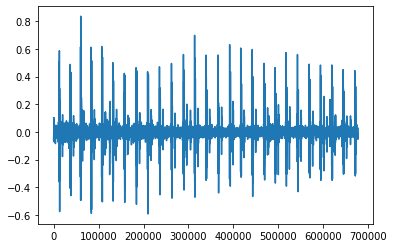

In [4]:
wav, sr = load_wave_file(wav_path+'training-a/a0409.wav')
plt.plot(wav)

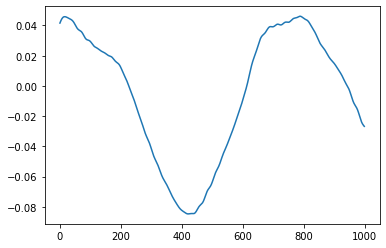

In [5]:
plt.plot(wav[3500:4500])

# Lets Differntiate between normal and abnormal records

In [6]:
training_a = pd.read_csv('/Users/taposh/Downloads/heart_sound/training-a/REFERENCE-SQI.csv',names=["wavfile", "actuals", "pred"])
training_b = pd.read_csv('/Users/taposh/Downloads/heart_sound/training-b/REFERENCE-SQI.csv',names=["wavfile", "actuals", "pred"])
training_c = pd.read_csv('/Users/taposh/Downloads/heart_sound/training-c/REFERENCE-SQI.csv',names=["wavfile", "actuals", "pred"])
training_d = pd.read_csv('/Users/taposh/Downloads/heart_sound/training-d/REFERENCE-SQI.csv',names=["wavfile", "actuals", "pred"])
training_e = pd.read_csv('/Users/taposh/Downloads/heart_sound/training-e/REFERENCE-SQI.csv',names=["wavfile", "actuals", "pred"])
training_f = pd.read_csv('/Users/taposh/Downloads/heart_sound/training-f/REFERENCE-SQI.csv',names=["wavfile", "actuals", "pred"])

In [7]:
train = pd.concat([training_a, training_b,training_c,training_d,training_e,training_f], axis=0)

In [8]:
category_group = train[['wavfile', 'actuals', 'pred']].groupby(['actuals','pred']).count()
category_group

wavfile
actuals pred         
-1      0         271
        1        2304
 1      0          93
        1         572

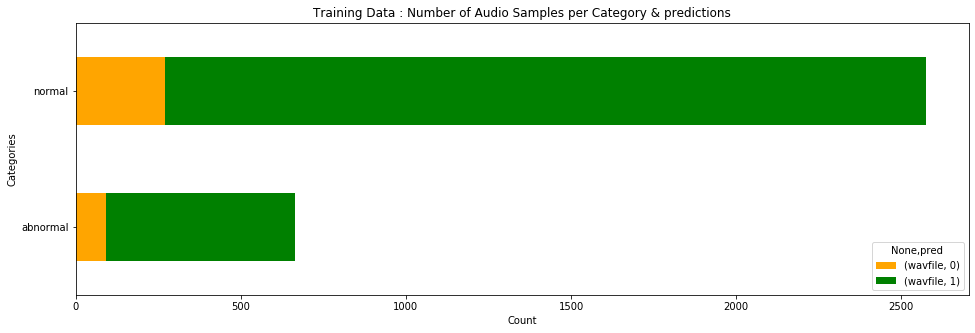

In [9]:
# Note: there are 2 types of wave files - Normal (-1) and Abnormal (1)

catlabels = ['abnormal', 'normal']
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='barh', stacked=True, title="Training Data : Number of Audio Samples per Category & predictions",color=["orange","green"], figsize=(16,5))
plot.set_yticklabels(catlabels)
plot.set_xlabel("Count")
plot.set_ylabel("Categories");


## Lets Listen and Visualize each class

In [10]:
#Helper Function
def get_wave_path(wav_file_name,wav_path):
    if (wav_file_name[0] =='a'):
        wav_path = wav_path + "training-a/" + wav_file_name +".wav"
        #print(wav_path)
    elif (wav_file_name[0] =='b'):
        wav_path = wav_path + "training-b/" + wav_file_name +".wav"
    elif (wav_file_name[0] =='c'):
        wav_path = wav_path + "training-c/" + wav_file_name +".wav"
    elif (wav_file_name[0] =='d'):
        wav_path = wav_path + "training-d/" + wav_file_name +".wav"
    elif (wav_file_name[0] =='e'):
        wav_path = wav_path + "training-e/" + wav_file_name +".wav"
    elif (wav_file_name[0] =='f'):
        wav_path = wav_path + "training-f/" + wav_file_name +".wav"
    return wav_path

In [11]:

normals = train.query('actuals == "1"')['wavfile'].tolist()
#print(wav_path)
normal_sound_file = get_wave_path(str(normals[1]),wav_path)
#print(sound_file)
Audio(normal_sound_file)

In [14]:
#plot a normal wave
normal_wav, sr = load_wave_file(normal_sound_file)
#Abnormals
abnormals = train.query('actuals == "-1"')['wavfile'].tolist()
#print(wav_path)
abnormal_sound_file = get_wave_path(str(abnormals[1]),wav_path)
#plot a normal wave
abnormal_wav, sr = load_wave_file(abnormal_sound_file)

#print(sound_file)
Audio(abnormal_sound_file)


## Visualize the normal and abnormal files side by size

Text(0.5, 1.0, 'Abnormal Wave')

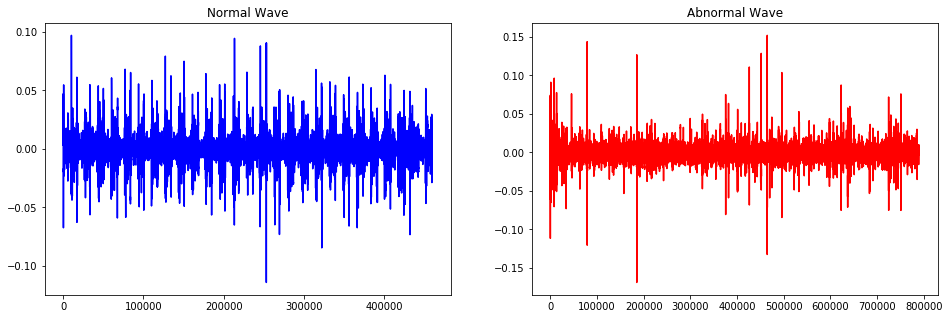

In [15]:
# Plot the normal and Abnormal sound waves side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(normal_wav,color="b")
axes[0].set_title('Normal Wave')
axes[1].plot(abnormal_wav,color="r")
axes[1].set_title('Abnormal Wave')

## Audio File Duration

One other thing to note here is the audio file duration. The first file was 20 sec while the 2nd one was 35 secs. There are two approaches to addressing this are:

1. Pad the audio with zeros to given length
2. Repeat audio to given length, for example max length of all audio samples

Also, note our library Librosa has the default sampling rate set to 22050 ( fyi, you can change this or use raw sampling rate) 

In [16]:
#Sampling Rate

sample_rate = 22050
print(librosa.get_duration(normal_wav))
print(len(normal_wav)/sample_rate)

print(librosa.get_duration(abnormal_wav))
print(len(abnormal_wav)/sample_rate)
print("\n This confirms the default sample rate used by Librosa")


#let set the audio to be 5 secs
atime = 5
audio_len = atime*sample_rate
print("\n We would set our audio length for all files to be :" + str(audio_len))


20.828526077097507
20.828526077097507
35.80553287981859
35.80553287981859

 This confirms the default sample rate used by Librosa

 We would set our audio length for all files to be :110250


In [61]:
"""Zero Padding all files"""
def zero_pad_allfiles(files):
    pathfiles = list(map(lambda x: get_wave_path(x,wav_path),files))
    wave_files = []
    for file in pathfiles:
        wav, sr = load_wave_file(file)
        #pad by audio length
        wav_pad = zero_pad(wav, audio_len)  
        wave_files.append(wav_pad)
    return wave_files


"""Finds max length of all files"""
def get_max_len(files):
    maxL = 0
    for file in files:
        wav, sr = load_wav_file(file, wav_path)
        if len(wav) > maxL:
            maxL = len(wav)
    
    return maxL

"""Cuts arrays under length or and pads arrays over length with zeros"""
def zero_pad(arr, length):
    l = len(arr)
    if l > length:
        result = arr[0:length]
    else:
        zero_pad = np.zeros(length - l)
        result = np.concatenate([arr, zero_pad])
    return result

"""Repeats np 1D array to given length, and makes datatype float"""
def repeat_to_len(arr, length):
    result = np.empty((length, ), dtype = 'float32')
    l = len(arr)
    pos = 0
    while pos + l <= length:
        result[pos:pos+l] = arr
        pos += l
    if pos < length:
        result[pos:length] = arr[:length-pos]
    return result

"""Cuts 2d arrays under length or and pads arrays over length with zeros """
def zero_pad_2d(arr, length):
    l = arr.shape[1]
    if l > length:
        result = arr[:,0:length]
    else:
        zero_pad = np.zeros((arr.shape[0], length - arr.shape[1]))
        result = np.hstack((arr, zero_pad))
        
    return result

"""Function to plot ROC curve and other metrics"""
def plot_roc(y_test, y_pred, y_prob):  
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return fpr, tpr, thresholds

In [18]:
files = list(train['wavfile'])
wave_files = zero_pad_allfiles(files)

In [20]:
#lets look at what we have 
fivefiles = pd.DataFrame(wave_files[0:5])
fivefiles

,0,1,2,3,4,5,6,7,8,9,...,110240,110241,110242,110243,110244,110245,110246,110247,110248,110249
0,-0.002031,-0.002270,-0.002509,-0.002746,-0.002979,-0.003204,-0.003418,-0.003617,-0.003798,-0.003958,...,0.007677,0.007840,0.008020,0.008211,0.008410,0.008614,0.008821,0.009027,0.009232,0.009436
1,0.009013,0.010394,0.011809,0.013233,0.014643,0.016013,0.017320,0.018543,0.019662,0.020662,...,0.000194,0.000347,0.000498,0.000646,0.000790,0.000929,0.001064,0.001195,0.001323,0.001449
2,-0.003980,-0.004654,-0.005329,-0.005990,-0.006621,-0.007206,-0.007732,-0.008188,-0.008567,-0.008863,...,-0.085973,-0.085281,-0.084585,-0.083888,-0.083189,-0.082491,-0.081795,-0.081104,-0.080418,-0.079740
3,0.010882,0.012339,0.013764,0.015125,0.016395,0.017549,0.018566,0.019430,0.020130,0.020663,...,-0.008964,-0.008999,-0.009029,-0.009052,-0.009068,-0.009076,-0.009078,-0.009072,-0.009059,-0.009041
4,-0.001735,-0.001949,-0.002150,-0.002334,-0.002497,-0.002634,-0.002745,-0.002827,-0.002883,-0.002911,...,0.006714,0.007043,0.007361,0.007669,0.007964,0.008247,0.008519,0.008779,0.009028,0.009269


# Training the Model with the raw_data 

In [53]:
#Labels as Actuals 
y_data = train['actuals']
x_data = np.vstack(wave_files)
#split data
x_train, x_test, y_train, y_test, train_filenames, test_filenames = train_test_split(x_data, y_data, train['wavfile'].values, test_size=0.3)

In [52]:
pd.DataFrame(x_train).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2268 entries, 0 to 2267
Columns: 110250 entries, 0 to 110249
dtypes: float64(110250)
memory usage: 1.9 GB


In [43]:
nn_model = Sequential()
nn_model.add(Dense(256, input_shape=x_train[0].shape, activation='relu', kernel_regularizer=l2(0.02)))
nn_model.add(Dense(48, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               28224256  
_________________________________________________________________
dense_9 (Dense)              (None, 48)                12336     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 49        
Total params: 28,236,641
Trainable params: 28,236,641
Non-trainable params: 0
_________________________________________________________________


In [44]:
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [54]:
hist = nn_model.fit(x_train, y_train, epochs=20, batch_size=32,validation_data=(x_test, y_test),verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 2268 samples, validate on 972 samples
Epoch 1/20
 - 29s - loss: -5.0563e-01 - acc: 0.0115 - val_loss: -2.5414e+00 - val_acc: 0.0000e+00
Epoch 2/20
 - 27s - loss: -4.2422e+00 - acc: 0.0000e+00 - val_loss: -3.3761e+00 - val_acc: 0.0000e+00
Epoch 3/20
 - 27s - loss: -4.5536e+00 - acc: 0.0000e+00 - val_loss: -3.1247e+00 - val_acc: 0.0000e+00
Epoch 4/20
 - 27s - loss: -4.1860e+00 - acc: 0.0000e+00 - val_loss: -3.6158e+00 - val_acc: 0.0000e+00
Epoch 5/20
 - 27s - loss: -4.5888e+00 - acc: 0.0000e+00 - val_loss: -2.9233e+00 - val_acc: 0.0000e+00
Epoch 6/20
 - 27s - loss: -4.8994e+00 - acc: 0.0000e+00 - val_loss: -3.9560e+00 - val_acc: 0.0000e+00
Epoch 7/20
 - 27s - loss: -4.4824e+00 - acc: 0.0000e+00 - val_loss: -4.6798e+00 - val_acc: 0.0000e+00
Epoch 8/20
 - 27s - loss: -5.6509e+00 - acc: 0.0000e+00 - val_loss: -3.7436e+00 - val_acc: 0.0000e+00
Epoch 9/20
 - 27s - loss: -4.4489e+00 - acc: 0.0000e+00 - val_loss: -4.4006e+00 - val_acc: 0.

## Raw Data - Results .... Needs Improvement !!

In [57]:
pred_prob = nn_model.predict(x_test)
pred_classes = [1 if x >= 0.5 else 0 for x in pred_prob]

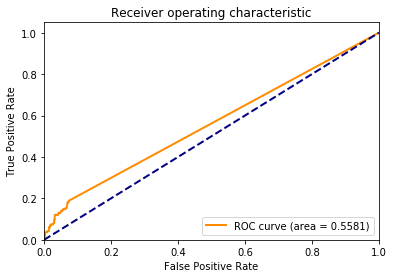

In [67]:
fpr, tpr, thresholds = plot_roc(y_test, pred_classes, pred_prob)

In [68]:
accuracy_score(y_test, pred_classes)

0.04218106995884774